## Models comparison
Once that we have trained the four different models, we want to compare their performance on the validation set.

In [1]:
# Import all the necessary modules
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,optimizer=None,device=cpu,floatX=float32"
import sys
sys.path.insert(0,'..')
import numpy as np
import theano
import theano.tensor as T
import lasagne
from confusionmatrix import ConfusionMatrix
from utils import iterate_minibatches, LSTMAttentionDecodeFeedbackLayer
from models import *
import matplotlib.pyplot as plt
import time
import itertools
%matplotlib inline

### Load validation set
We load the validation set as before, but now we set the batch_size to be equal to the size of the dataset. We do this because we want don't need to divide the dataset at inference time, as it is quite fast even with many examples.

In [2]:
validation = np.load('data/reduced_val.npz')
X_val = validation['X_val']
y_val = validation['y_val']
mask_val = validation['mask_val']
print(X_val.shape)

(635, 400, 20)


In [3]:
batch_size = X_val.shape[0]
seq_len = 400
n_feat = 20
n_hid = 15
n_class = 10
lr = 0.0025
n_filt = 10
drop_prob = 0.5

### Compile the four different models
The models architecture are defined in the script 'models.py'. They are exactly the same as the ones in the previous notebooks. Here we are compiling them again and returning the validation function and the empty network parameters.

In [13]:
_, val_fn_ffn, ffn_params = FFN(batch_size, seq_len, n_hid, n_feat, n_class, lr, drop_prob)
_, val_fn_cnn, cnn_params = CNN(batch_size, seq_len, n_hid, n_feat, n_class, n_filt, lr, drop_prob)
_, val_fn_cnn_lstm, cnn_lstm_params = CNN_LSTM(batch_size, seq_len, n_hid, n_feat, n_class, n_filt, lr, drop_prob)
_, val_fn_cnn_lstm_att, cnn_lstm_att_params = CNN_LSTM_Att(batch_size, seq_len, n_hid, n_feat, n_class, n_filt, lr, drop_prob)

### Load networks parameters
Once that the four models have been built, we load the learned parameters for each model.

In [5]:
with np.load('params/FFN_params.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
lasagne.layers.set_all_param_values(ffn_params, param_values)
with np.load('params/CNN_params.npz') as f:
    param_values = [f['arr_%d' % i].astype(np.float32) for i in range(len(f.files))]
lasagne.layers.set_all_param_values(cnn_params, param_values)
with np.load('params/CNN-LSTM_params.npz') as f:
    param_values = [f['arr_%d' % i].astype(np.float32) for i in range(len(f.files))]
lasagne.layers.set_all_param_values(cnn_lstm_params, param_values)
with np.load('params/CNN-LSTM-Attention_params.npz') as f:
    param_values = [f['arr_%d' % i].astype(np.float32) for i in range(len(f.files))]
lasagne.layers.set_all_param_values(cnn_lstm_att_params, param_values)

### Calculate validation performance
The last step is to run our data through the models and calculate the loss and the accuracy on the validation set.

#### Feedforward neural network

In [6]:
# Initialize confusion matrix
confusion_ffn = ConfusionMatrix(n_class)
# Perform prediction
err_ffn, predict_ffn = val_fn_ffn(X_val.astype(np.float32), y_val.astype(np.int32))
preds_ffn = np.argmax(predict_ffn, axis=-1)
# Calculate accuracy
confusion_ffn.batch_add(y_val, preds_ffn)
ffn_accuracy = confusion_ffn.accuracy()
cf_ffn = confusion_ffn.ret_mat()

#### Convolutional neural network

In [7]:
# Initialize confusion matrix
confusion_cnn = ConfusionMatrix(n_class)
# Perform prediction
err_cnn, predict_cnn = val_fn_cnn(X_val.astype(np.float32), y_val.astype(np.int32))
preds_cnn = np.argmax(predict_cnn, axis=-1)
# Calculate accuracy
confusion_cnn.batch_add(y_val, preds_cnn)
cnn_accuracy = confusion_cnn.accuracy()
cf_cnn = confusion_cnn.ret_mat()

#### Convolutional LSTM

In [8]:
# Initialize confusion matrix
confusion_cnn_lstm = ConfusionMatrix(n_class)
# Perform prediction
err_cnn_lstm, predict_cnn_lstm = val_fn_cnn_lstm(
    X_val.astype(np.float32), y_val.astype(np.int32), mask_val.astype(np.float32))
preds_cnn_lstm = np.argmax(predict_cnn_lstm, axis=-1)
# Calculate accuracy
confusion_cnn_lstm.batch_add(y_val, preds_cnn_lstm)
cnn_lstm_accuracy = confusion_cnn_lstm.accuracy()
cf_cnn_lstm = confusion_cnn_lstm.ret_mat()

#### Convolutional LSTM with attention mechanism

In [9]:
# Initialize confusion matrix
confusion_cnn_lstm_att = ConfusionMatrix(n_class)
# Perform prediction
err_cnn_lstm_att, predict_cnn_lstm_att, alphas = val_fn_cnn_lstm_att(
    X_val.astype(np.float32), y_val.astype(np.int32), mask_val.astype(np.float32))
preds_cnn_lstm_att  = np.argmax(predict_cnn_lstm_att, axis=-1)
# Calculate accuracy
confusion_cnn_lstm_att.batch_add(y_val, preds_cnn_lstm_att)
cnn_lstm_att_accuracy = confusion_cnn_lstm_att.accuracy()
cf_cnn_lstm_att = confusion_cnn_lstm_att.ret_mat()

### Comparison
Finally, we plot the loss and the accuracy for each model. We can observe that the CNN-LSTM-Attention achieves best performance.

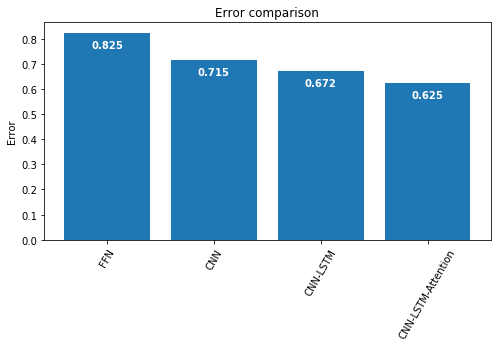

In [10]:
plt.figure(figsize=(8,4))
x = np.arange(4)
errors = [err_ffn,err_cnn,err_cnn_lstm,err_cnn_lstm_att]
plt.bar(x, errors)
plt.title('Error comparison')
plt.ylabel('Error')
plt.xticks(x, ['FFN','CNN','CNN-LSTM','CNN-LSTM-Attention'], rotation=60)
for i, v in enumerate(errors):
    plt.text(i-0.15,v-0.06, '%.3f' % v, color='white',fontweight='bold');

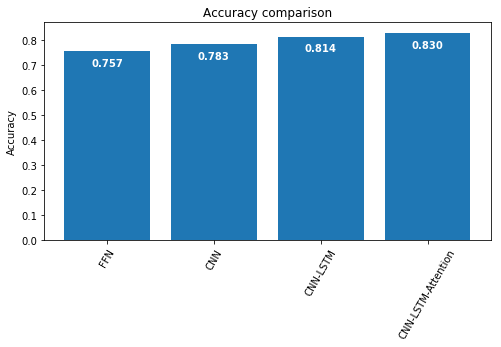

In [11]:
plt.figure(figsize=(8,4))
x = np.arange(4)
accs = [ffn_accuracy,cnn_accuracy,cnn_lstm_accuracy,cnn_lstm_att_accuracy]
plt.bar(x, accs)
plt.title('Accuracy comparison')
plt.ylabel('Accuracy')
plt.xticks(x, ['FFN','CNN','CNN-LSTM','CNN-LSTM-Attention'], rotation=60)
for i, v in enumerate(accs):
    plt.text(i-0.15,v-0.06, '%.3f' % v, color='white',fontweight='bold');